In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import holidays
import pickle

In [73]:
# Load the data splits from the pickle file
with open('timeseries_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

# Extract the training and validation data
train_df = data_splits['train']
val_df = data_splits['validation']

print('Training set:', train_df.shape)
print('Validation set:', val_df.shape)

Training set: (8199, 2)
Validation set: (2050, 2)


/home/adel_hb/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


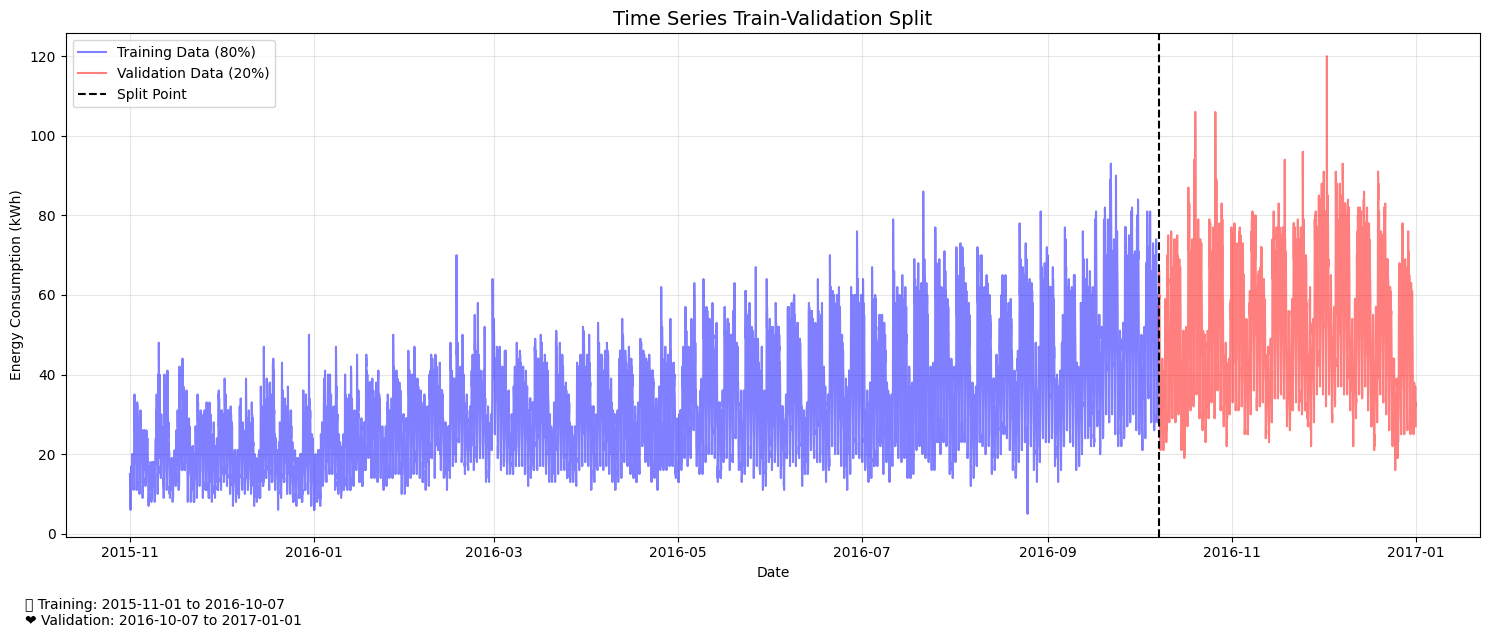

In [74]:

# Cell 2: Visualize Split
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'],
         color='blue', alpha=0.5, label='Training Data (80%)')

# Plot validation data
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'],
         color='red', alpha=0.5, label='Validation Data (20%)')

# Add split line
split_date = train_df['DateTime'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')

# Customize plot
plt.title('Time Series Train-Validation Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add explanation
plt.figtext(0.02, -0.05, 
            f'🟢 Training: {train_df["DateTime"].min().date()} to {train_df["DateTime"].max().date()}\n' +
            f'❤️ Validation: {val_df["DateTime"].min().date()} to {val_df["DateTime"].max().date()}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

In [75]:
# 2. Prepare data
def create_features(df):
    df = df.copy()
    # Time-based features
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['quarter'] = df['DateTime'].dt.quarter
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    df['dayofmonth'] = df['DateTime'].dt.day
    df['weekofyear'] = df['DateTime'].dt.isocalendar().week
    
    # Holiday feature
    us_holidays = holidays.US()
    df['is_holiday'] = df['DateTime'].isin(us_holidays).astype(int)
    
    return df

# Prepare features for both train and validation sets
train_features = create_features(train_df)
val_features = create_features(val_df)

# Define feature columns
feature_columns = ['hour', 'dayofweek', 'quarter', 'month', 'year', 
                  'dayofyear', 'dayofmonth', 'weekofyear', 'is_holiday']

# Prepare training and validation sets
X_train = train_features[feature_columns]
y_train = train_features['EnergyConsumption(kWh)']
X_val = val_features[feature_columns]
y_val = val_features['EnergyConsumption(kWh)']

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

In [76]:
# 3. Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# 4. Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val), 
                    callbacks=[early_stopping, reduce_lr], verbose=1)

/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 619.8290 - val_loss: 220.0381 - learning_rate: 0.0010
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95.9960 - val_loss: 169.0460 - learning_rate: 0.0010
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87.5381 - val_loss: 166.8454 - learning_rate: 0.0010
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 90.6266 - val_loss: 174.9767 - learning_rate: 0.0010
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87.8675 - val_loss: 164.4686 - learning_rate: 0.0010
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 87.4720 - val_loss: 165.3105 - learning_rate: 0.0010
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 86.9565 - val_loss: 163.8829 - learning_rate: 0.0010
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 83.1235 - val_loss: 154.0946 - learning_rate: 0.0010
Epoch 9/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 81.4240 - val_loss: 147.93

In [77]:
# 5. Make predictions and evaluate
val_predictions = model.predict(X_val_scaled)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


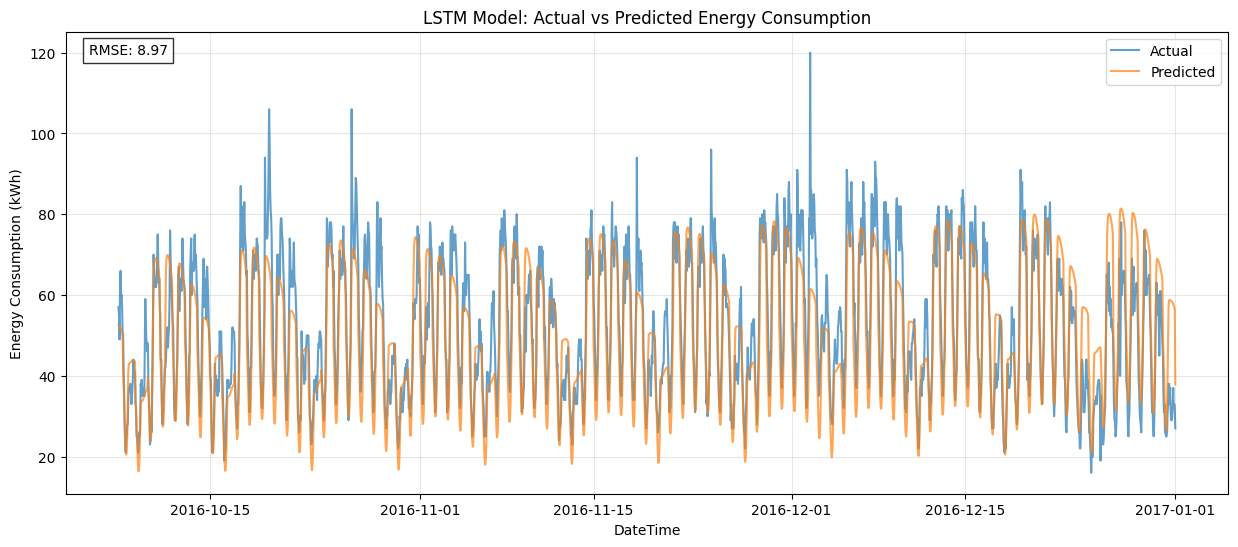


Model Performance Metrics:
RMSE: 8.97


In [78]:
# Visualize results
plt.figure(figsize=(15, 6))

# Plot actual vs predicted
plt.plot(val_features['DateTime'], y_val, label='Actual', alpha=0.7)
plt.plot(val_features['DateTime'], val_predictions, label='Predicted', alpha=0.7)
plt.title('LSTM Model: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.02, 0.95), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

print(f"\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f}")

In [79]:
# 6. Prepare test data
test_data = pd.read_csv('data/test_energy.csv')
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Create features for test data
test_features = create_features(test_data)

# Ensure the same feature columns are used
X_test = test_features[feature_columns]

# Scale the test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Make predictions on test data
test_predictions = model.predict(X_test_scaled)

# Create submission file
submission = pd.DataFrame({
    'DateTime': test_data['DateTime'],
    'EnergyConsumption(kWh)': test_predictions.flatten()
})

submission.to_csv('lstm_submission.csv', index=False)

print("Submission file created successfully!")

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Submission file created successfully!
